In [1]:
# Installing `caer` and `canaro` since they don't come pre-installed
!pip install caer canaro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 809 kB 5.8 MB/s 
     |████████████████████████████████| 17.9 MB 61.4 MB/s 


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [4]:
import opendatasets as od

https://github.com/JovianML/opendatasets/blob/master/README.md#kaggle-credentials

opendatasets is a Python library for downloading datasets from online sources like Kaggle and Google Drive using a simple Python command.

Datasets can be downloaded within a Jupyter notebook or Python script using the opendatasets.download

Kaggle Credentials
opendatasets uses the Kaggle Official API for donwloading dataset from Kaggle. Follow these steps to find your API credentials:

Go to https://kaggle.com/me/account (sign in if required).

Scroll down to the "API" section and click "Create New API Token". This will download a file kaggle.json with the following contents:

{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}

In [5]:
od.download("https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: atenarashidi
Your Kaggle Key: ··········


100%|██████████| 1.08G/1.08G [00:07<00:00, 162MB/s]


In [6]:
IMG_SIZE = (80, 80)
channels = 1
char_path = r"/content/the-simpsons-characters-dataset/simpsons_dataset"

In [7]:
char_dict = {}
for char in os.listdir(char_path):
  char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending = True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [8]:
characters = []
count = 0
for item in char_dict:
    characters.append(item[0])
    count += 1
    if count >= 10:
      break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [9]:
# Creat the training Data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.009806394577026367s
[INFO] At 1000 files
[INFO] 1454 files found in 0.0044460296630859375s
[INFO] At 1000 files
[INFO] 1452 files found in 0.0037899017333984375s
[INFO] At 1000 files
[INFO] 1354 files found in 0.004082202911376953s
[INFO] At 1000 files
[INFO] 1342 files found in 0.006986379623413086s
[INFO] At 1000 files
[INFO] 1291 files found in 0.0035054683685302734s
[INFO] At 1000 files
[INFO] 1206 files found in 0.0032596588134765625s
[INFO] At 1000 files
[INFO] 1194 files found in 0.003240823745727539s
[INFO] At 1000 files
[INFO] 1193 files found in 0.0036766529083251953s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0031578540802001953s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 33s


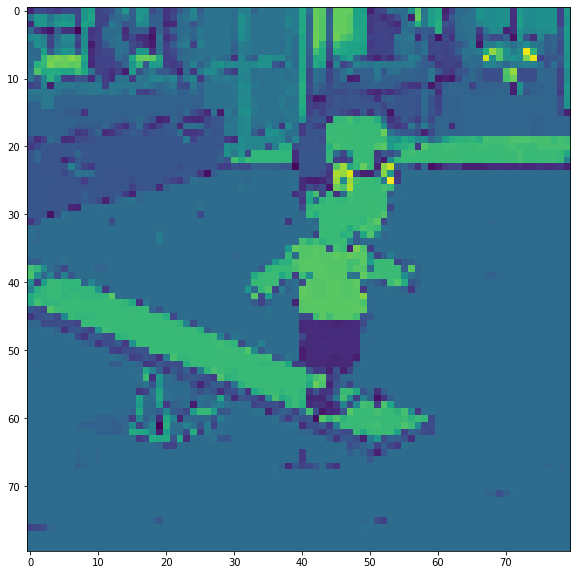

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(train[0][0])
plt.show()

In [11]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [12]:
# We don't have normalized label 
# Normalize the featureset --> (0,1)
featureSet = caer.normalize(featureSet)

# to Convert Categorical Data to Numerical Data, we use One-Hot Encoding
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, num_classes=len(characters))

In [13]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=0.2)

In [14]:
del train
del featureSet
del labels
gc.collect

<function gc.collect(generation=2)>

In [15]:
BATCH_SIZE = 32
EPOCHS = 10

In [16]:
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size = BATCH_SIZE) 

In [17]:
# Creating model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters),
                                          loss = 'binary_crossentropy', decay = 1e-6,
                                          learning_rate=0.001, momentum=0.9, nesterov = True)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 80, 80, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 39, 39, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 37, 64)        36928     
                                                      

In [19]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.1543

345/345 [==============================] - 21s 35ms/step - loss: 0.3410 - accuracy: 0.1543 - val_loss: 0.3342 - val_accuracy: 0.1596 - lr: 0.0100
Epoch 2/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3233 - accuracy: 0.1605 - lr: 0.0100
Epoch 3/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3229 - accuracy: 0.1635 - lr: 0.0100
Epoch 4/10
345/345 [==============================] - 10s 29ms/step - loss: 0.3177 - accuracy: 0.1815 - lr: 0.0100
Epoch 5/10
345/345 [==============================] - 10s 30ms/step - loss: 0.3080 - accuracy: 0.2240 - lr: 0.0100
Epoch 6/10
345/345 [==============================] - 10s 30ms/step - loss: 0.3038 - accuracy: 0.2466 - lr: 0.0100
Epoch 7/10
345/345 [==============================] - 10s 30ms/step - loss: 0.3006 - accuracy: 0.2619 - lr: 0.0100
Epoch 8/10
345/345 [==============================] - 11s 32ms/step - loss: 0.2989 - accuracy: 0.2754 - lr: 0.0100
Epoch 9/10
345/345 [=============================

In [20]:
# Testing

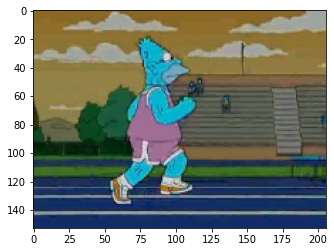

In [21]:
test_path = r'/content/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/abraham_grampa_simpson_1.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [22]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [23]:
predictions = model.predict(prepare(img))
predictions

1/1 [==============================] - 0s 242ms/step


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [24]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

lisa_simpson


Sources:
https://github.com/jasmcaus/caer

https://www.youtube.com/watch?v=oXlwWbU8l2o


